## Notebook for visualisation testing

In [1]:
import numpy as np
import pandas as pd
import sys

In [2]:
sys.path.append('d:/gsn-projekt')

In [3]:
confmat = np.array([[10,2,0],
                    [3,15,1],
                    [1,4,20]])

In [4]:
confmat

array([[10,  2,  0],
       [ 3, 15,  1],
       [ 1,  4, 20]])

Code from [https://github.com/wcipriano/pretty-print-confusion-matrix](https://github.com/wcipriano/pretty-print-confusion-matrix) 

In [5]:
from amphibian.visual import ConfusionMatrix

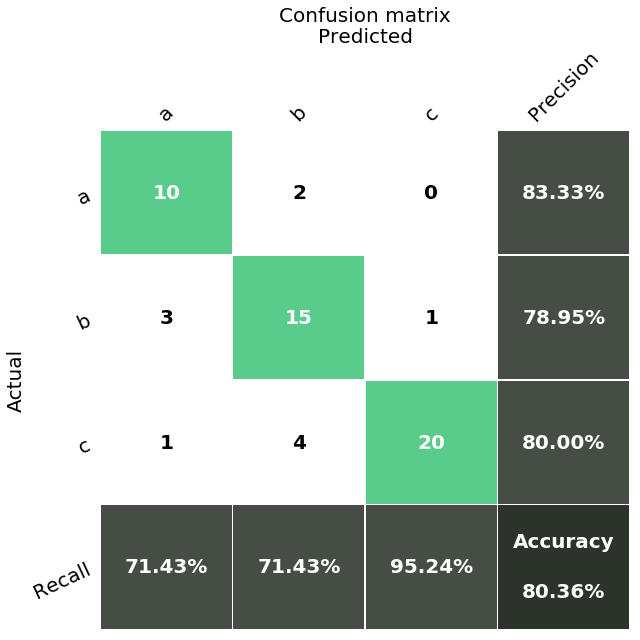

In [6]:
ConfusionMatrix(confmat, ['a', 'b', 'c']).plot(fontsize=20)

In [84]:
cm.compute_metrics()

array([[10.        ,  2.        ,  0.        ,  0.83333333],
       [ 3.        , 15.        ,  1.        ,  0.78947368],
       [ 1.        ,  4.        , 20.        ,  0.8       ],
       [ 0.71428571,  0.71428571,  0.95238095,  0.80357143]])

## MAVI

In [3]:
import datetime
import torch

from scipy import stats
from torchvision import transforms
from torch.utils.data import DataLoader

import amphibian.preprocess.preprocessing as preproc
from amphibian.fetch.reader import AmphibianReader
from amphibian.preprocess.train_test_split import TrainTestSplit
from amphibian.architectures import RNNModel, AttentionModel
from amphibian.train import SingleTrainer, batch_size_dist, CrossValidation

In [6]:
DATA_PATH = r'D:\gsn-projekt\data\all_values\stocks\try_all'
ar = AmphibianReader(DATA_PATH, datetime.datetime(2011, 1, 1), datetime.datetime(2018, 1, 1))
_ = ar.create_torch()
tts = TrainTestSplit(ar, int_start=0, int_end=1000)

In [8]:
WINDOW_WIDTH = 10

In [9]:
tsds = preproc.TimeSeriesDataset(tts, int_len=WINDOW_WIDTH, transform=transforms.Compose([
    preproc.FillNaN(), preproc.Normalizing(), preproc.DummyFillNaN(), preproc.Formatting(), 
    preproc.FormattingY()
]))

d:\gsn-projekt\venv\lib\site-packages\torch\tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [10]:
vds = preproc.ValidDataset(tsds)

In [16]:
dl = DataLoader(vds, batch_size=256)

In [23]:
for i, batch in enumerate(dl):
    print(batch['test_obs'].shape)

torch.Size([256, 10, 60])
torch.Size([256, 10, 60])
torch.Size([256, 10, 60])
torch.Size([256, 10, 60])
torch.Size([256, 10, 60])
torch.Size([256, 10, 60])
torch.Size([256, 10, 60])
torch.Size([118, 10, 60])


In [29]:
ten = ar.torch['AMERICA']

In [41]:
ten.shape

torch.Size([1816, 6, 10])

In [40]:
ten[0,:,:]

tensor([[1.7310e+01, 3.8000e+01, 4.0140e+01, 5.3700e+00, 9.6576e+00, 8.8000e+00,
         7.9750e+01, 2.7000e+01, 3.0210e+01, 1.3500e+00],
        [1.7000e+01, 3.7030e+01, 3.9760e+01, 5.1600e+00, 9.3066e+00, 8.4700e+00,
         7.9020e+01, 2.5900e+01, 2.9720e+01, 1.2300e+00],
        [1.7020e+01, 3.7320e+01, 3.9840e+01, 5.3500e+00, 9.5640e+00, 8.8000e+00,
         7.9020e+01, 2.6840e+01, 2.9810e+01, 1.2500e+00],
        [1.7250e+01, 3.7060e+01, 4.0020e+01, 5.2700e+00, 9.3690e+00, 8.5700e+00,
         7.9430e+01, 2.6620e+01, 3.0060e+01, 1.3000e+00],
        [7.0794e+07, 2.4875e+07, 3.8200e+05, 2.7310e+05, 9.7257e+05, 1.0690e+05,
         3.9710e+05, 1.2830e+06, 2.3433e+06, 5.3570e+05],
        [1.2499e+01, 2.9610e+01, 3.1693e+01, 5.2700e+00, 8.0855e+00, 8.5700e+00,
         6.3193e+01, 2.6620e+01, 2.8616e+01, 1.3000e+00]], device='cuda:0')

In [44]:
ten.resize(ten.size(0), 1, ten[0, :, :].numel()).squeeze()[0,:]

tensor([1.7310e+01, 3.8000e+01, 4.0140e+01, 5.3700e+00, 9.6576e+00, 8.8000e+00,
        7.9750e+01, 2.7000e+01, 3.0210e+01, 1.3500e+00, 1.7000e+01, 3.7030e+01,
        3.9760e+01, 5.1600e+00, 9.3066e+00, 8.4700e+00, 7.9020e+01, 2.5900e+01,
        2.9720e+01, 1.2300e+00, 1.7020e+01, 3.7320e+01, 3.9840e+01, 5.3500e+00,
        9.5640e+00, 8.8000e+00, 7.9020e+01, 2.6840e+01, 2.9810e+01, 1.2500e+00,
        1.7250e+01, 3.7060e+01, 4.0020e+01, 5.2700e+00, 9.3690e+00, 8.5700e+00,
        7.9430e+01, 2.6620e+01, 3.0060e+01, 1.3000e+00, 7.0794e+07, 2.4875e+07,
        3.8200e+05, 2.7310e+05, 9.7257e+05, 1.0690e+05, 3.9710e+05, 1.2830e+06,
        2.3433e+06, 5.3570e+05, 1.2499e+01, 2.9610e+01, 3.1693e+01, 5.2700e+00,
        8.0855e+00, 8.5700e+00, 6.3193e+01, 2.6620e+01, 2.8616e+01, 1.3000e+00],
       device='cuda:0')

In [48]:
13 % 5

3

In [32]:
ten[0,:,:].numel()

60